# Streaming machine learning on Arduino

## Setup the environment

### Loading the datset

In [1]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('elecNormNew.arff')
df = pd.DataFrame(data[0])
print(df.size)

df.head(20)

def convert(x):
    if x.decode() == 'UP':
        return 1
    else:
        return 0

y_true = list(map(convert,df['class'].values.tolist()))

407808


In [20]:
print(str(df['date'][0]))

def stringBuilder(df,x):
    # Build a string from the data in the dataframe
    string = str(df['nswprice'][x]) + ',' + str(df['nswdemand'][x]) + ',' + str(df['vicprice'][x]) + ',' + str(df['vicdemand'][x]) + ',' + str(df['transfer'][x]) + ',' + str(y_true[x])
    return string
print(stringBuilder(df,0))
print(stringBuilder(df,5))

0.0
0.056443,0.439155,0.003467,0.422915,0.414912,1
0.041161,0.207528,0.003467,0.422915,0.414912,0


### Install pyserial

In [ ]:
%pip install pyserial

## Run

### Start streaming the dataset over serial

In [45]:
import serial

serialPort = serial.Serial(port="COM10", baudrate=500000, bytesize=8, timeout= None, rtscts=False)

# Configuration
step = 100
config = 'partitionDim: ' + str(step) +','

res = ""
while 'start sending data' not in res: 
    res = serialPort.readline().decode()
    print(res)
    if 'waiting for configuration msg' in res:
        serialPort.write(config.encode())


# Start sending data
predictions = []
predTime = []
trainTime = []
counter = 0

for partition in range(0, 4500, step):
    data = ""
    for i in range(partition, partition + step):
        data += stringBuilder(df,i) + ',;'
    #print(data)
    serialPort.write(data.encode())

    res = serialPort.readline().decode()
    #print(res)
    samples = res.split(';')
    for x in range(0,len(samples)-1):
        sample = samples[x]
        for out in sample.split(','):
            if 'predicted:' in out:
                predict = int(out.split(':')[1])
                #print(predict)
                predictions.append(predict)   
                if (predict == y_true[partition+x]):
                    counter += 1
            if 'prediction_time:' in out:
                predTime.append(int(out.split(':')[1]))
            if 'train_time:' in out:
                trainTime.append(int(out.split(':')[1]))


    print('accuracy after '+ str(partition+step) + ': '+ "{:.3f}".format(counter/(partition+step)), end='')
    print(', avg pred time: ' + str(int(sum(predTime)/len(predTime))) + 'μs, avg train time: ' + str(int(sum(trainTime)/len(trainTime))) + 'μs')
    print()
print('accuracy: ' + str(counter/len(predictions)))
serial.Serial.close(serialPort)


Serial started

waiting for configuration msg

configuration msg received

partitionDim: 100

start sending data

accuracy after 100: 0.790, avg pred time: 414μs, avg train time: 71μs

accuracy after 200: 0.800, avg pred time: 436μs, avg train time: 71μs

accuracy after 300: 0.737, avg pred time: 448μs, avg train time: 71μs

accuracy after 400: 0.748, avg pred time: 452μs, avg train time: 71μs

accuracy after 500: 0.692, avg pred time: 456μs, avg train time: 71μs

accuracy after 600: 0.692, avg pred time: 460μs, avg train time: 71μs

accuracy after 700: 0.687, avg pred time: 461μs, avg train time: 71μs

accuracy after 800: 0.708, avg pred time: 461μs, avg train time: 71μs

accuracy after 900: 0.703, avg pred time: 463μs, avg train time: 71μs

accuracy after 1000: 0.714, avg pred time: 466μs, avg train time: 71μs

accuracy after 1100: 0.701, avg pred time: 468μs, avg train time: 71μs

accuracy after 1200: 0.707, avg pred time: 470μs, avg train time: 71μs

accuracy after 1300: 0.707, avg

### Analize the results

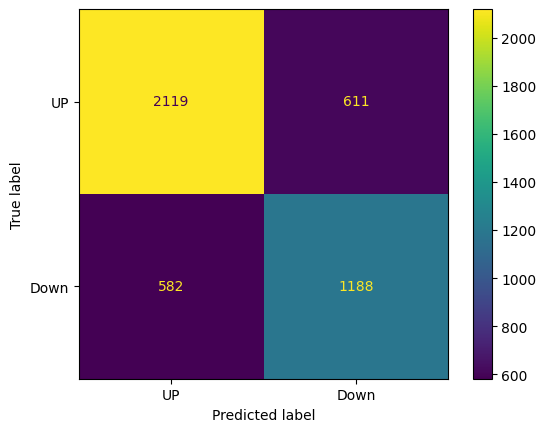

              precision    recall  f1-score   support

          UP       0.78      0.78      0.78      2730
        Down       0.66      0.67      0.67      1770

    accuracy                           0.73      4500
   macro avg       0.72      0.72      0.72      4500
weighted avg       0.74      0.73      0.74      4500

accuracy after 4500: 0.735, avg pred time: 476μs, avg train time: 71μs



In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

start = 0
end = len(predictions)

yy_true = y_true[start:end]
y_pred = predictions[start:end]
#print(df['class'].values.tolist()[start:end])
#print(yy_true)
#print(y_pred)
confusion_matrix = confusion_matrix(yy_true, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['UP', 'Down'])

cm_display.plot()
plt.show()
print(metrics.classification_report(yy_true, y_pred, target_names = ['UP', 'Down']))
print('accuracy after '+ str(partition+step) + ': '+ "{:.3f}".format(counter/(partition+step)), end='')
print(', avg pred time: ' + str(int(sum(predTime)/len(predTime))) + 'μs, avg train time: ' + str(int(sum(trainTime)/len(trainTime))) + 'μs')
print()